![forecasting_framework](../forecasting_framework.png)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from statsmodels.tsa.stattools import adfuller, kpss

from math import sqrt

In [30]:
TRAIN_CSV_PATH = r"../datasets/train.csv"
PRICES_CSV_PATH = r"../datasets/prices.csv"
CAL_CSV_PATH = r"../datasets/calendar.csv"
SAMPLE_CSV_PATH = r"../datasets/sample_submission.csv"

EXPORT_PATH = r"../submissions/"

In [3]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

In [4]:
def plot_differencing(series, n = 8) :

    fig, axes = plt.subplots(n, 3, figsize = (20,25))

    axes[0, 0].plot(series); axes[0, 0].set_title('Original Series')
    plot_acf(series, ax=axes[0, 1])

    for i in range(1, n) :
        diff_series = series.diff(periods = i)

        axes[i, 0].plot(diff_series); axes[i, 0].set_title(f'{i}th Order Differencing')
        plot_acf(diff_series.dropna(), ax=axes[i, 1])
        plot_pacf(diff_series.dropna(), method='ywm', ax = axes[i, 2])


    plt.show()

In [5]:
df_train = pd.read_csv(TRAIN_CSV_PATH)
df_train.head()

,id,item_id,subcat_id,category_id,store_id,region_id,d_1,d_2,d_3,d_4,...,d_1910,d_1911,d_1912,d_1913,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919
0,Beauty_1_001_East_1,Beauty_1_001,Beauty_1,Beauty,East_1,East,0,0,0,0,...,3,0,1,1,0,0,0,2,0,3
1,Beauty_1_002_East_1,Beauty_1_002,Beauty_1,Beauty,East_1,East,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,Beauty_1_003_East_1,Beauty_1_003,Beauty_1,Beauty,East_1,East,0,0,0,0,...,0,1,1,1,0,0,1,1,0,2
3,Beauty_1_004_East_1,Beauty_1_004,Beauty_1,Beauty,East_1,East,0,0,0,0,...,1,3,7,2,0,0,1,2,4,1
4,Beauty_1_005_East_1,Beauty_1_005,Beauty_1,Beauty,East_1,East,0,0,0,0,...,2,2,2,4,1,0,2,3,1,0


In [6]:
# Convert to appropriate datatypes
df_train["id"] = df_train["id"].astype("string")
df_train["item_id"] = df_train["item_id"].astype("string")
df_train["subcat_id"] = df_train["subcat_id"].astype("string")
df_train["category_id"] = df_train["category_id"].astype("string")
df_train["store_id"] = df_train["store_id"].astype("string")
df_train["region_id"] = df_train["region_id"].astype("string")

In [7]:
df_cal = pd.read_csv(CAL_CSV_PATH)
df_cal.head()

,date,wm_yr_wk,weekday,wday,month,year,d
0,2011-01-29,11101,Saturday,1,1,2011,d_1
1,2011-01-30,11101,Sunday,2,1,2011,d_2
2,2011-01-31,11101,Monday,3,1,2011,d_3
3,2011-02-01,11101,Tuesday,4,2,2011,d_4
4,2011-02-02,11101,Wednesday,5,2,2011,d_5


In [8]:
# Change dtypes
df_cal["date"] = pd.to_datetime(df_cal["date"])
df_cal["weekday"] = df_cal["weekday"].astype("string")
df_cal["d"] = df_cal["d"].astype("string")
df_cal["wm_yr_wk"] = df_cal["wm_yr_wk"].astype(int)

# Add column with months in string
month_names_ls = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
month_int_ls = list(range(1, 13))
month_names_dict = {month_int_ls[i]: month_names_ls[i] for i in range(len(month_int_ls))}

df_cal["month_name"] = df_cal["month"].replace(month_names_dict)

In [9]:
# Save day IDs from train
day_ids = list(df_train.columns[6:])

df_items_temp = df_train[["id"]+day_ids].T
df_items_temp.columns = df_items_temp.iloc[0, :]

# Drop first row
df_items_temp = df_items_temp.iloc[1: , :]

# Copy the index to merge date
df_items_temp["d"] = df_items_temp.index

# Merge date into df
df_items_temp = pd.merge(df_items_temp, df_cal, on = "d", how = "left")
df_items_temp = df_items_temp.set_index("date")

# Calculate average items across items per day
df_items_temp["avg_items_sold"] = df_items_temp[list(df_train["id"])].mean(axis = 1)

In [10]:
df_items_temp.head()

,Beauty_1_001_East_1,Beauty_1_002_East_1,Beauty_1_003_East_1,Beauty_1_004_East_1,Beauty_1_005_East_1,Beauty_1_006_East_1,Beauty_1_007_East_1,Beauty_1_008_East_1,Beauty_1_009_East_1,Beauty_1_010_East_1,...,Food_3_826_West_3,Food_3_827_West_3,d,wm_yr_wk,weekday,wday,month,year,month_name,avg_items_sold
date,,,,,,,,,,,,,,,,,,,,,
2011-01-29,0,0,0,0,0,0,0,12,2,0,...,0,0,d_1,11101,Saturday,1,1,2011,Jan,1.070220
2011-01-30,0,0,0,0,0,0,0,15,0,0,...,0,0,d_2,11101,Sunday,2,1,2011,Jan,1.041292
2011-01-31,0,0,0,0,0,0,0,0,7,1,...,0,0,d_3,11101,Monday,3,1,2011,Jan,0.780026
2011-02-01,0,0,0,0,0,0,0,0,3,0,...,0,0,d_4,11101,Tuesday,4,2,2011,Feb,0.833454
2011-02-02,0,0,0,0,0,0,0,0,0,0,...,0,0,d_5,11101,Wednesday,5,2,2011,Feb,0.627944


#### Plot differencing for lag 1 - 7

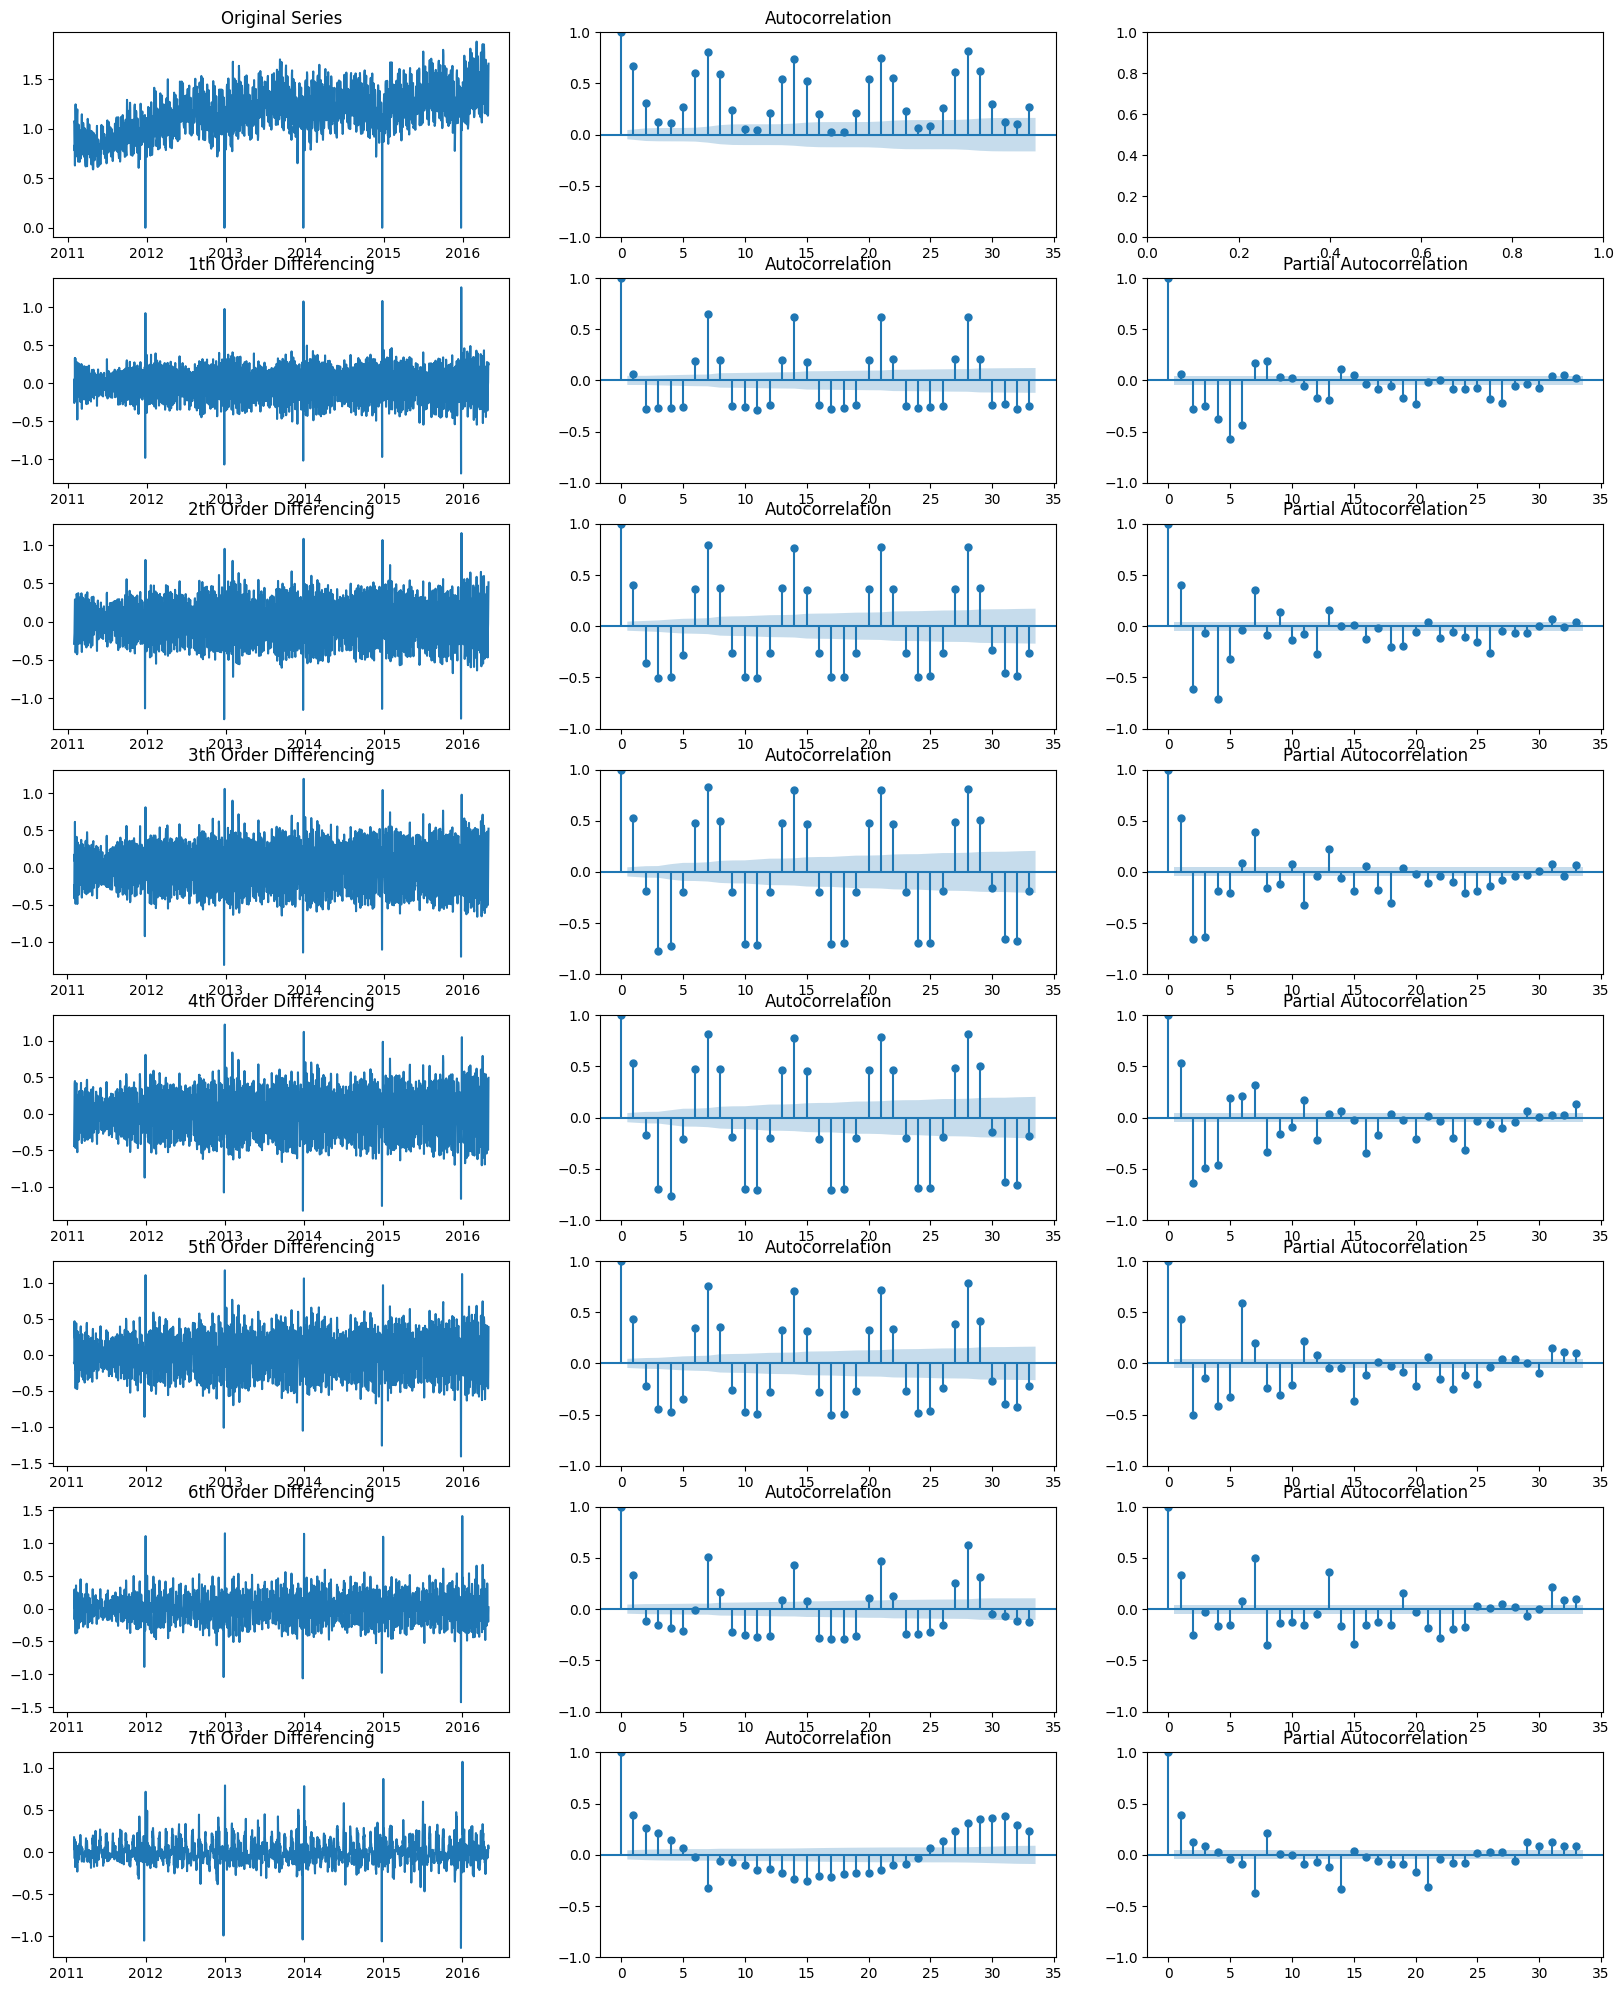

In [11]:
plot_differencing(df_items_temp["avg_items_sold"])

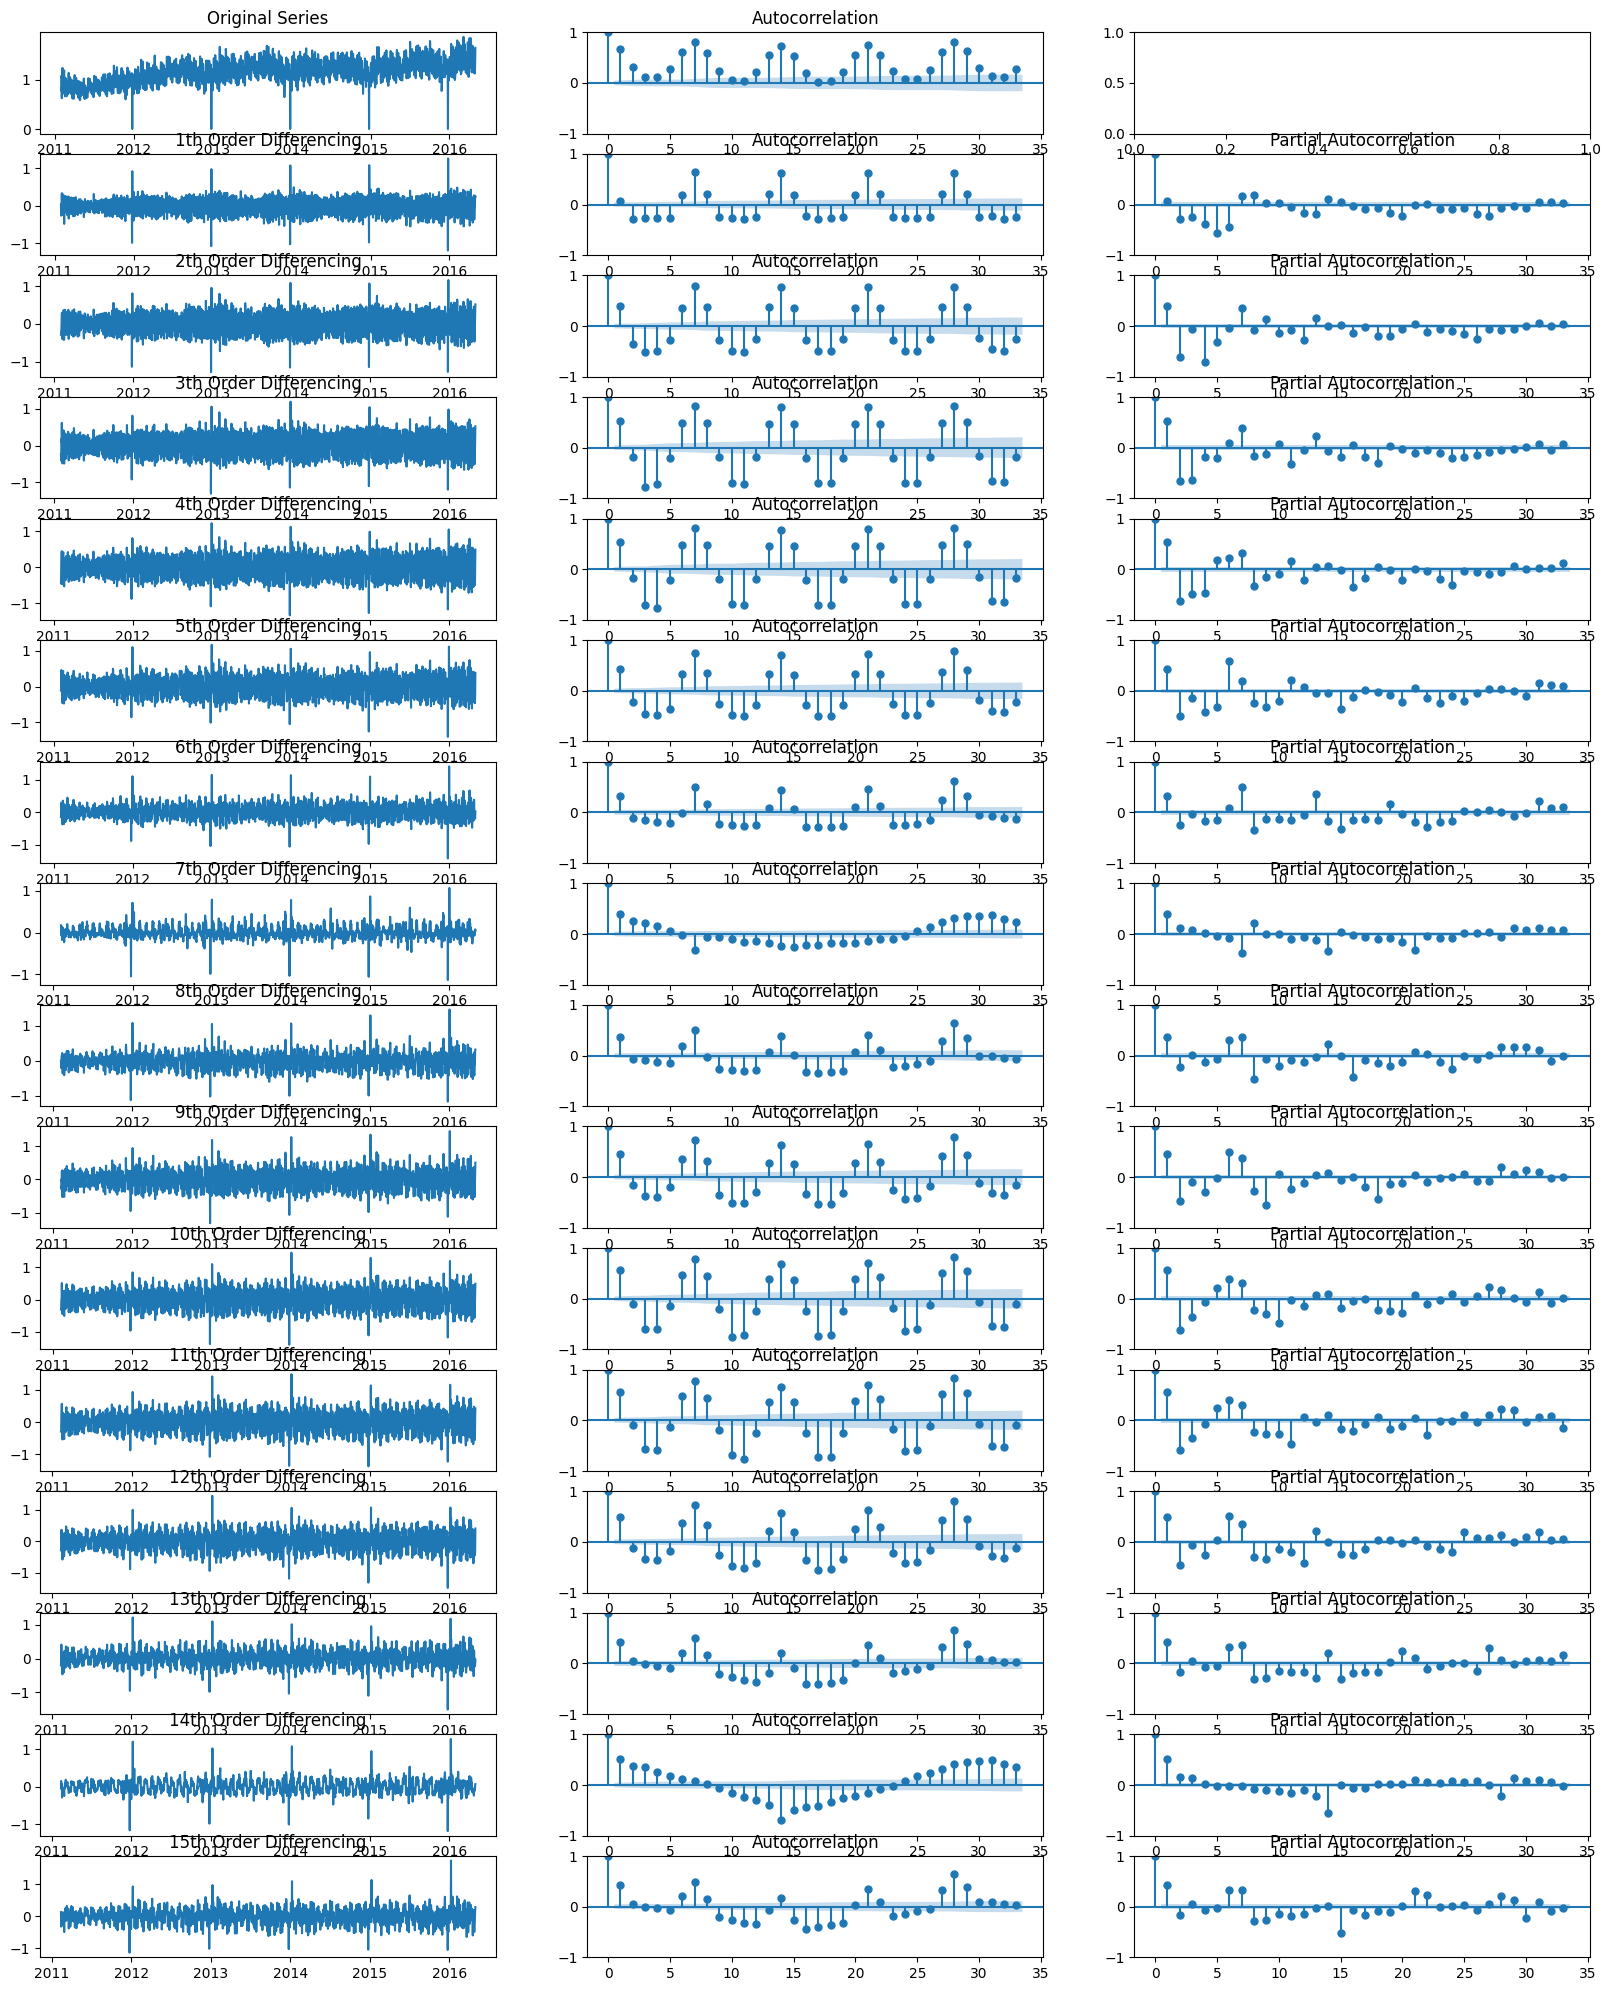

In [12]:
plot_differencing(df_items_temp["avg_items_sold"], n = 16)

#### Test for stationarity after differencing by 7

In [13]:
adf_test(df_items_temp["avg_items_sold"].diff(periods = 7).dropna())

Results of Dickey-Fuller Test:
Test Statistic                  -20.958364
p-value                           0.000000
#Lags Used                       23.000000
Number of Observations Used    1888.000000
Critical Value (1%)              -3.433818
Critical Value (5%)              -2.863072
Critical Value (10%)             -2.567586
dtype: float64


In [14]:
kpss_test(df_items_temp["avg_items_sold"].diff(periods = 7).dropna())

Results of KPSS Test:
Test Statistic            0.008453
p-value                   0.100000
Lags Used                19.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


c:\Users\Tristan\Desktop\Assignments\ADS\ads-final-project\ads_env\lib\site-packages\statsmodels\tsa\stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


In [15]:
df_items_temp["avg_items_sold"].diff(periods = 7).dropna()

date
2011-02-05    0.173860
2011-02-06    0.032371
2011-02-07    0.058675
2011-02-08   -0.076779
2011-02-09    0.147983
                ...   
2016-04-26   -0.068317
2016-04-27   -0.029452
2016-04-28   -0.009872
2016-04-29    0.078026
2016-04-30    0.048114
Name: avg_items_sold, Length: 1912, dtype: float64

#### Things to do (Vasu)

1. Better understanding SARIMA and how to derive the parameters from the ACF and PACF plots
2. Trying different test sizes, lmk what you think is a reasonable test size considering that the final forecast is 21 days 
3. Producing forecast in the form of sample_submission.csv, i.e. items sold per item per day

### Testing ARIMA model on average items sold

Fitting on the entire dataset, and then producing the forecast for a subset of the data.

Copying the code from [here](https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/)
 and [here](https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/)

In [16]:
x = df_items_temp["avg_items_sold"]

model = ARIMA(x, order = (1, 1, 1), seasonal_order=(1,1,1,7))
fitted = model.fit()

c:\Users\Tristan\Desktop\Assignments\ADS\ads-final-project\ads_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Tristan\Desktop\Assignments\ADS\ads-final-project\ads_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Tristan\Desktop\Assignments\ADS\ads-final-project\ads_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


TODO: How to interpret results summary below? 

If P>|z| = 0.000, does that imply that results are very significant, or that there was some error? 

In [17]:
print(fitted.summary())

                                    SARIMAX Results                                    
Dep. Variable:                  avg_items_sold   No. Observations:                 1919
Model:             ARIMA(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood                1586.543
Date:                         Sun, 23 Apr 2023   AIC                          -3163.086
Time:                                 22:17:08   BIC                          -3135.310
Sample:                             01-29-2011   HQIC                         -3152.864
                                  - 04-30-2016                                         
Covariance Type:                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3965      0.012     31.743      0.000       0.372       0.421
ma.L1         -0.9627      0.007   -130.033      0.000     

#### Residuals plot

Does the plot show that most of the variance was captured? Other than the outliers at the end of each year

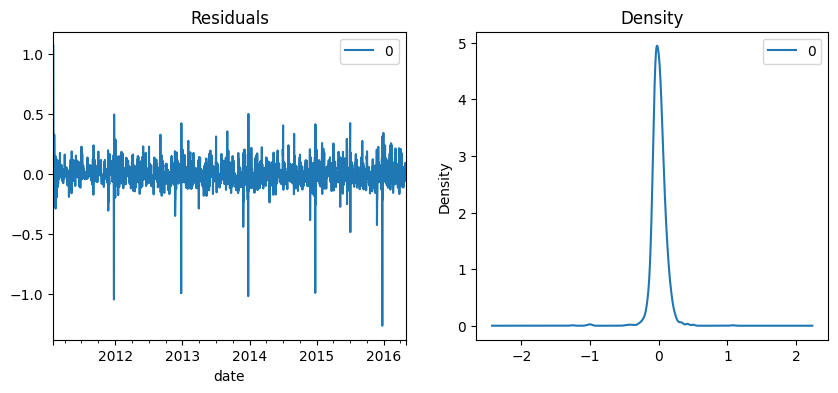

In [18]:
residuals = pd.DataFrame(fitted.resid)
fig, ax = plt.subplots(1,2, figsize = (10, 4))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

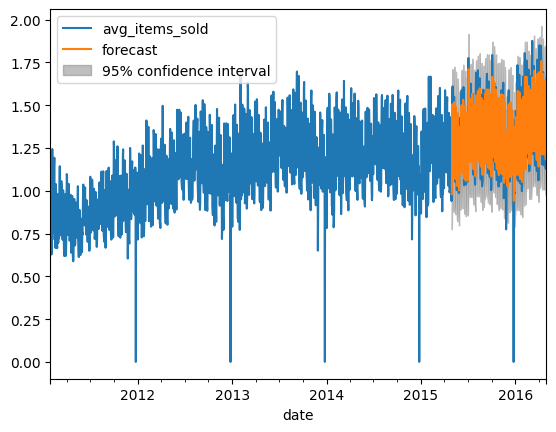

In [19]:
# Actual vs Fitted
fig, ax = plt.subplots()
ax = df_items_temp["avg_items_sold"].plot(ax=ax)

# Predict until last day
plot_predict(fitted, "2015-04-30", "2016-04-30", ax = ax)
plt.show()

In [20]:
preds = fitted.get_prediction("2015-04-30", "2016-04-30")
rmse = sqrt(mean_squared_error(df_items_temp.loc["2015-04-30":"2016-04-30"]["avg_items_sold"], preds.predicted_mean))
print(rmse)

0.11978358626513931


### Forecasting with ARIMA

Using 80% of the data to train, then testing on a forecast of the next 90 days (because Kaggle submission is only for the next 21 days)

TODO: Consider other window forecasts? Is this a realistic estimate of performance, because the test size is so small?

TODO: Try other combinations of AR and MA, including the seasonal order component.

In [21]:
# Set number of days to forecast into the future
n = 90

# Split into test and train
size = int(len(x) * 0.8)
x_train, x_test = x[0:size], x[size:size+n]

# Build Model
model = ARIMA(x_train, order = (3, 1, 1), seasonal_order=(1,1,1,7))
fitted = model.fit()

# Forecast n days ahead
fc = fitted.forecast(n) 

# Make as pandas series
fc_series = pd.Series(fc, index=df_items_temp["avg_items_sold"][size:size+n].index)

c:\Users\Tristan\Desktop\Assignments\ADS\ads-final-project\ads_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Tristan\Desktop\Assignments\ADS\ads-final-project\ads_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Tristan\Desktop\Assignments\ADS\ads-final-project\ads_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Tristan\Desktop\Assignments\ADS\ads-final-project\ads_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [22]:
print(fitted.summary())

                                    SARIMAX Results                                    
Dep. Variable:                  avg_items_sold   No. Observations:                 1535
Model:             ARIMA(3, 1, 1)x(1, 1, 1, 7)   Log Likelihood                1341.656
Date:                         Sun, 23 Apr 2023   AIC                          -2669.313
Time:                                 22:17:13   BIC                          -2631.995
Sample:                             01-29-2011   HQIC                         -2655.423
                                  - 04-12-2015                                         
Covariance Type:                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3574      0.015     23.735      0.000       0.328       0.387
ar.L2          0.0860      0.024      3.652      0.000     

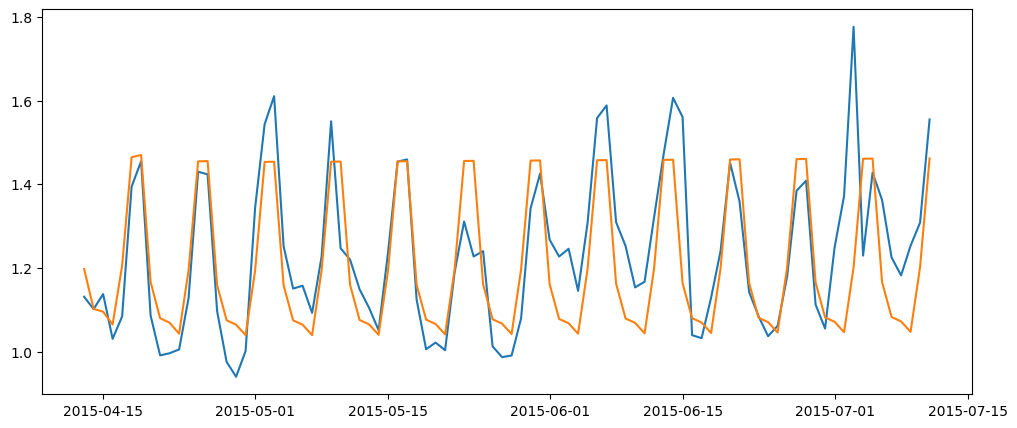

In [23]:
plt.figure(figsize=(12,5), dpi=100)
# plt.plot(x_train, label='training')
plt.plot(x_test, label='actual')
plt.plot(fc_series, label='forecast')
plt.show()

In [24]:
rmse = sqrt(mean_squared_error(x_test, fc_series))
print(rmse)

0.12633555999975635


### Forecast test 1 

Super simple method, training data is aggregated average across all items and all days in the train dataset.

Forecast all 21 days at once and assign predictions to all the items for all days.

In [90]:
df_sample_sub = pd.read_csv(SAMPLE_CSV_PATH)

# Create new df for submission
df_sub = pd.DataFrame(columns=df_sample_sub.columns)
df_sub.head()

,id,d_1920,d_1921,d_1922,d_1923,d_1924,d_1925,d_1926,d_1927,d_1928,...,d_1931,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940


In [85]:
# Build Model -  just average items sold first
model = ARIMA(df_items_temp["avg_items_sold"], order = (3, 1, 1), seasonal_order=(1,1,1,7))
fitted = model.fit()

print(fitted.summary())

c:\Users\Tristan\Desktop\Assignments\ADS\ads-final-project\ads_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Tristan\Desktop\Assignments\ADS\ads-final-project\ads_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Tristan\Desktop\Assignments\ADS\ads-final-project\ads_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                    SARIMAX Results                                    
Dep. Variable:                  avg_items_sold   No. Observations:                 1919
Model:             ARIMA(3, 1, 1)x(1, 1, 1, 7)   Log Likelihood                1606.115
Date:                         Sun, 23 Apr 2023   AIC                          -3198.231
Time:                                 22:56:45   BIC                          -3159.343
Sample:                             01-29-2011   HQIC                         -3183.919
                                  - 04-30-2016                                         
Covariance Type:                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3723      0.016     23.855      0.000       0.342       0.403
ar.L2          0.0860      0.022      3.914      0.000     

c:\Users\Tristan\Desktop\Assignments\ADS\ads-final-project\ads_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [94]:
# Forecast n days ahead
fc = fitted.forecast(21) 
pred_time_period = pd.date_range(start = "2016-05-01", periods = 21)

# Make as pandas series
fc_series = pd.Series(fc).round().astype(int)

# Assign to all items
df_sample_sub.iloc[:,1:] = fc_series.values

In [112]:
# Export
# df_sample_sub.to_csv(EXPORT_PATH+"/submission_1.csv", header=True, index=False)

#### Rolling forecast ARIMA model

Copying code from [here](https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/)

In [23]:
# history = [x for x in x_train]
# predictions = list()

# for t in range(len(x_test)):
    
#     # Order taken from eda (hypothesis after looking at plots) 
#     print(t)
#     model = ARIMA(history, order=(11,7,8))
#     model_fit = model.fit()
#     output = model_fit.forecast()
#     yhat = output[0]
#     predictions.append(yhat)
#     obs = x_test[t]
#     history.append(obs)
#     # print('predicted=%f, expected=%f' % (yhat, obs))

0


c:\Users\Tristan\Desktop\Assignments\ADS\ads-final-project\ads_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Tristan\Desktop\Assignments\ADS\ads-final-project\ads_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


1


c:\Users\Tristan\Desktop\Assignments\ADS\ads-final-project\ads_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


2


c:\Users\Tristan\Desktop\Assignments\ADS\ads-final-project\ads_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


3


In [ ]:
# rmse = sqrt(mean_squared_error(x_test, predictions))
# print('Test RMSE: %.3f' % rmse)

In [ ]:
# plt.plot(x_test)
# plt.plot(predictions, color='red')
# plt.show()